In [1]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [2]:
## This notebook is to study the relationship between city-level Heat Exposure & temperature from weather station
## Read result from heat exposure
df = gpd.read_file('./output/census_tract_heat_exposure.shp')
df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,he_val,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,0.349523,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,0.304561,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,0.254064,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,0.314189,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,0.384308,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,0.445870,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,0.399139,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,0.312587,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,0.322456,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [3]:
## read temperature from NOAA

temp = pd.read_csv("./temp/2896807.csv")
temp

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
0,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2021-09-26,NaN,NaN,NaN,NaN
1,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2021-09-27,NaN,NaN,NaN,NaN
2,US1ILCK0306,"OAK FOREST 0.6 N, IL US",41.615500,-87.750700,199.3,2021-09-26,NaN,NaN,NaN,NaN
3,US1ILCK0306,"OAK FOREST 0.6 N, IL US",41.615500,-87.750700,199.3,2021-09-27,NaN,NaN,NaN,NaN
4,US1ILCK0148,"OAK LAWN 1.9 SE, IL US",41.693577,-87.728993,182.3,2021-09-26,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
240,US1ILDP0078,"NAPERVILLE 2.4 SE, IL US",41.741838,-88.116204,216.1,2021-09-27,NaN,NaN,NaN,NaN
241,US1INLK0063,"GARY 4.8 ENE, IN US",41.616955,-87.254631,186.5,2021-09-26,NaN,NaN,NaN,NaN
242,US1INLK0063,"GARY 4.8 ENE, IN US",41.616955,-87.254631,186.5,2021-09-27,NaN,NaN,NaN,NaN
243,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.960170,-87.931640,204.8,2021-09-26,66.0,83.0,54.0,NaN


In [4]:
## Filter the data to remove NaN column
valid_temp = temp[temp["TMAX"]> -459]
valid_temp

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
10,USC00116616,"PARK FOREST, IL US",41.49470,-87.68020,216.4,2021-09-26,NaN,70.0,49.0,54.0
11,USC00116616,"PARK FOREST, IL US",41.49470,-87.68020,216.4,2021-09-27,NaN,82.0,53.0,63.0
14,USC00115097,"LISLE MORTON ARBORETUM, IL US",41.81270,-88.07270,207.3,2021-09-26,NaN,70.0,48.0,51.0
15,USC00115097,"LISLE MORTON ARBORETUM, IL US",41.81270,-88.07270,207.3,2021-09-27,NaN,83.0,51.0,64.0
25,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",41.85580,-87.60940,177.7,2021-09-26,NaN,82.0,58.0,70.0
26,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",41.85580,-87.60940,177.7,2021-09-27,NaN,85.0,63.0,64.0
101,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.73720,-87.77750,189.0,2021-09-26,NaN,84.0,56.0,69.0
102,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.73720,-87.77750,189.0,2021-09-27,NaN,88.0,65.0,65.0
146,USW00004838,"CHICAGO PALWAUKEE AIRPORT, IL US",42.12076,-87.90479,191.6,2021-09-26,NaN,83.0,53.0,NaN
147,USW00004838,"CHICAGO PALWAUKEE AIRPORT, IL US",42.12076,-87.90479,191.6,2021-09-27,NaN,88.0,63.0,NaN


In [5]:
prev = []
curr = []

for index, row in valid_temp.iterrows():
    p = Point(float(row["LONGITUDE"]),float(row["LATITUDE"]))
    mint = row["TMIN"]
    maxt = row["TMAX"]
    meant = row["TAVG"]
    if (index%2==0):
        ## previous data
        prev.append([p, mint, maxt, meant])
    else:
        ## current data
        curr.append([p, mint, maxt, meant])
        


In [6]:
## Read temperature from weather underground
under_temp = pd.read_csv("./temp/weather.csv")
for index, row in under_temp.iterrows():
    p = Point(float(row["lon"]),float(row["lat"]))
    mint = row["926min"]
    maxt = row["926max"]
    meant = row["926mean"]
    prev.append([p,mint, maxt, meant])
    
    mint = row["927min"]
    maxt = row["927max"]
    meant = row["927mean"]
    curr.append([p,mint, maxt, meant])

In [18]:
(curr[0][3]>-459)==False

True

In [10]:
df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,he_val,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,0.349523,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,0.304561,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,0.254064,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,0.314189,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,0.384308,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,0.445870,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,0.399139,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,0.312587,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,0.322456,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [19]:
minprev = []
maxprev = []
mincurr = []
maxcurr = []
meanprev = []
meancurr = []

for index, row in df.iterrows():
    geom = row["geometry"]
    cent = geom.centroid
    #print(cent.x)
    ## IDW for 926min
    up = 0
    down = 0
    for ele in prev:
        weather_station_loc = ele[0]
        curr_temp = ele[1]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    minprev.append(up/down)
    
    ## IDW for 926max
    up = 0
    down = 0
    for ele in prev:
        weather_station_loc = ele[0]
        curr_temp = ele[2]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    maxprev.append(up/down)
    
    ## IDW for 926mean
    up = 0
    down = 0
    for ele in prev:
        weather_station_loc = ele[0]
        curr_temp = ele[3]
        if ( (curr_temp>-459)==False ):
            ## rule out nan
            continue
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    meanprev.append(up/down)
    
    ## IDW for 927min
    up = 0
    down = 0
    for ele in curr:
        weather_station_loc = ele[0]
        curr_temp = ele[1]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    mincurr.append(up/down)
    
    ## IDW for 927max
    up = 0
    down = 0
    for ele in curr:
        weather_station_loc = ele[0]
        curr_temp = ele[2]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    maxcurr.append(up/down)
    
    ## IDW for 927mean
    up = 0
    down = 0
    for ele in curr:
        weather_station_loc = ele[0]
        curr_temp = ele[3]
        if ( (curr_temp>-459)==False ):
            ## rule out nan
            continue
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    meancurr.append(up/down)

In [20]:
df["prevmin"]= minprev
df["prevmax"]= maxprev
df["prevmean"] = meanprev
df["currmin"]= mincurr
df["currmax"]= maxcurr
df["currmean"]=meancurr


In [21]:
df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,he_val,geometry,prevmin,prevmax,prevmean,currmin,currmax,currmean
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,0.349523,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",56.796654,84.014005,70.336438,63.738081,88.051792,72.048832
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,0.304561,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",56.822500,84.159304,70.408224,64.000447,88.321932,72.038836
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,0.254064,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",57.163931,84.079148,70.385153,63.876508,88.134674,72.004199
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,0.314189,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",56.794276,84.251544,70.456662,64.147015,88.525390,72.099221
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,0.384308,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",57.179112,83.711975,70.223604,63.965240,87.830419,71.787817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,0.445870,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",56.796699,84.255809,70.430345,64.372589,88.439618,71.985227
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,0.399139,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",56.838664,84.092327,70.276338,64.375202,88.184721,71.925401
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,0.312587,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",56.320092,83.990916,70.300608,64.070125,87.983891,71.625238
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,0.322456,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",56.724851,84.201013,70.416260,64.050955,88.363181,72.006646


In [25]:
y = list(df["he_val"])

In [26]:
x1 = list(df['prevmin'])
x2 = list(df['prevmax'])
x3 = list(df['currmin'])
x4 = list(df['currmax'])
## mean
x5 = list(df['prevmean'])
x6 = list(df['currmean'])

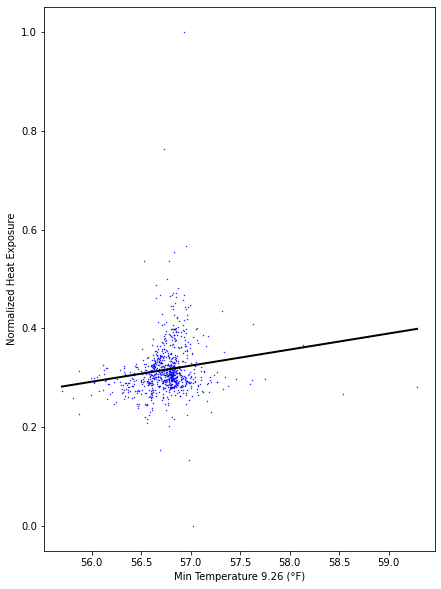

In [27]:
x = x1
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Min Temperature 9.26 (°F)')
plt.ylabel('Normalized Heat Exposure')

m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

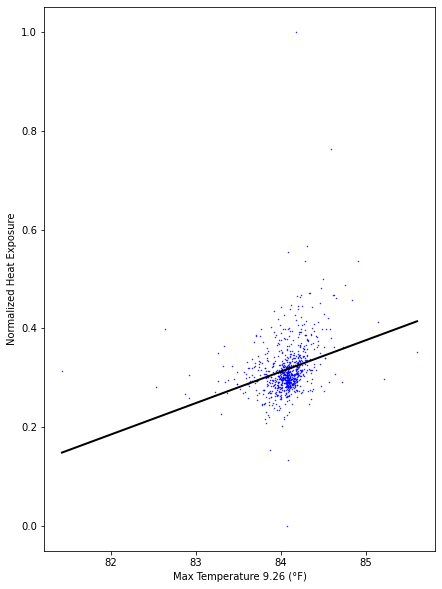

In [28]:
x = x2
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Max Temperature 9.26 (°F)' )
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

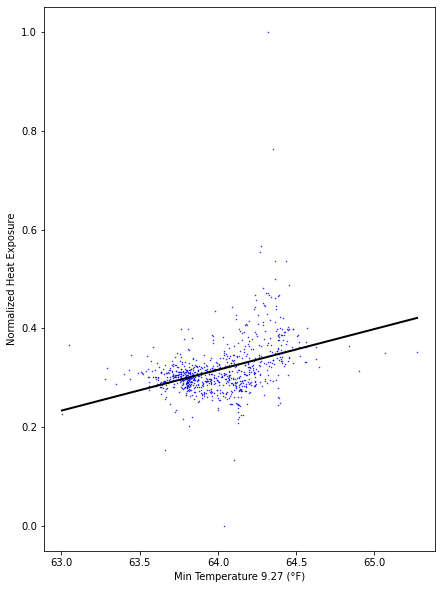

In [29]:
x = x3
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Min Temperature 9.27 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

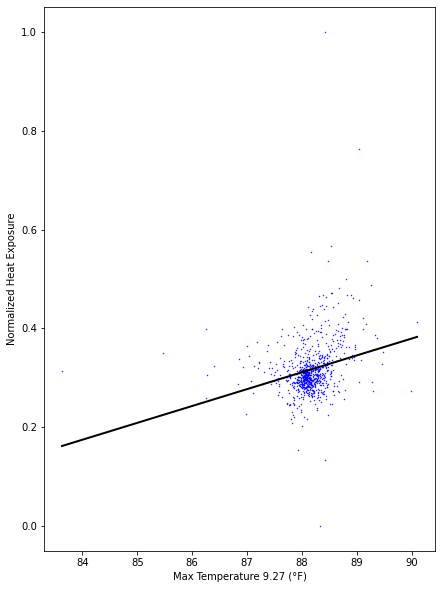

In [31]:
x = x4
y = y
plt.figure(figsize=(7, 10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Max Temperature 9.27 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

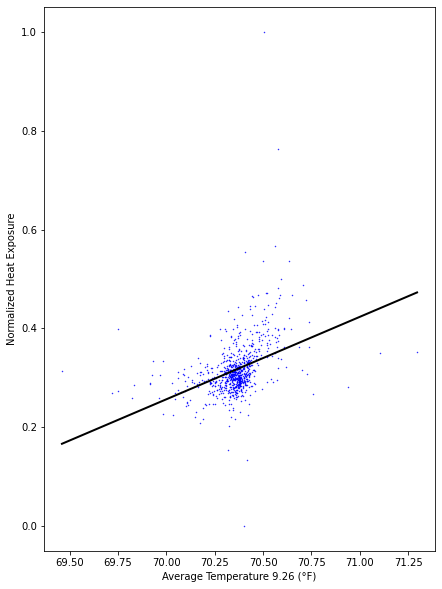

In [39]:
x = x5
y = y
plt.figure(figsize=(7, 10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Average Temperature 9.26 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

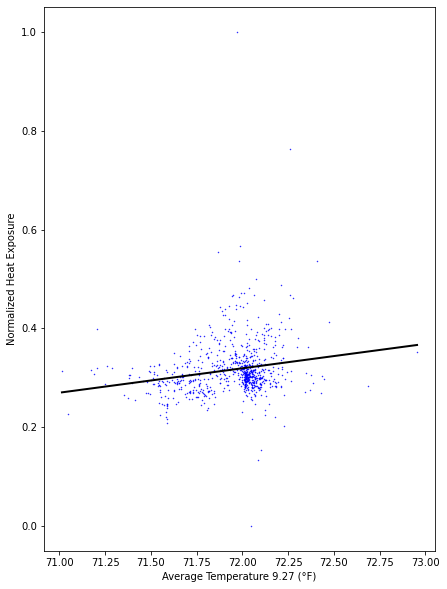

In [33]:
x = x6
y = y
plt.figure(figsize=(7, 10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Average Temperature 9.27 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

In [34]:
## ANOVA test
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('he_val~prevmin+prevmax+prevmean+currmin+currmax+currmean', data=df).fit()


In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 he_val   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     46.71
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           4.15e-49
Time:                        01:28:29   Log-Likelihood:                 1282.5
No. Observations:                 801   AIC:                            -2551.
Df Residuals:                     794   BIC:                            -2518.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.6485      1.014    -13.457      0.000     -15.639     -11.658
prevmin        0.0419      0.010      4.266      0.000       0.023       0.061
prevmax        0.0629      0.014      4.509      0.000       0.036       0.090
prevmean       0.0476      0.019      2.495      0.013       0.010       0.085
currmin        0.0729      0.008      9.417      0.000       0.058       0.088
currmax       -0.0079      0.007     -1.110      0.267      -0.022       0.006
currmean      -0.0142      0.015     -0.946      0.344      -0.044       0.015
==============================================================================
Omnibus:                      693.970   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69159.783
Skew:                           3.343   Prob(JB):                         0.00
Kurtosis:                      48.028   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
prevmin,0.043730,1.0,18.202856,2.225324e-05
prevmax,0.048851,1.0,20.334735,7.481137e-06
prevmean,0.014949,1.0,6.222786,1.281387e-02
currmin,0.213037,1.0,88.678464,4.912075e-20
currmax,0.002959,1.0,1.231826,2.673882e-01
currmean,0.002149,1.0,0.894698,3.444950e-01
Residual,1.907468,794.0,NaN,NaN


In [37]:
with open('./output/city_analysis_update.json', 'w') as f:
        f.write(df.to_json())

In [38]:
print(min(x1),max(x1))
print(min(x2),max(x2))
print(min(x3),max(x3))
print(min(x4),max(x4))
print(min(x5),max(x5))
print(min(x6),max(x6))

55.69771872382556 59.28808422161622
81.42717780689031 85.60595334714783
63.003061151999944 65.2723970839568
83.62945616302757 90.09163735011856
69.45979213026362 71.29606973174991
71.01361322274515 72.95387083896526
